In [1]:
import numpy as np
import random
import torch
from torch import nn, optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import cifar10_model_resnet as cifar10_model_resnet
model_file="cifar10_model_resnet.pt"
epochs=100
patience = 3
# patience_lr = 1
best_loss = float('inf')
counter = 0
counter_lr = 0

In [3]:
torch.manual_seed(10)
np.random.seed(10)
random.seed(10)

In [4]:
# transform=transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=(0.4914,0.4822,0.4465),
#         std=(0.2470,0.2435,0.2616))
# ])

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 隨機裁剪圖像
    transforms.RandomHorizontalFlip(),     # 隨機水平翻轉圖像
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616))
])

In [6]:
train_data = datasets.CIFAR10('data/cifar10/train', train=True, download=True, transform=transform_train)
print(train_data.data.shape)

Files already downloaded and verified
(50000, 32, 32, 3)


In [7]:
# train_data=datasets.CIFAR10('data/cifar10/train',train=True,download=True,transform=transform)
# print(train_data.data.shape)

In [8]:
dev_size=0.2
idx=list(range(len(train_data)))
np.random.shuffle(idx)
split_size=int(np.floor(dev_size*len(train_data)))
train_idx, dev_idx=idx[split_size:], idx[:split_size]
train_sampler=SubsetRandomSampler(train_idx)
dev_sampler=SubsetRandomSampler(dev_idx)

In [9]:
batch_size=300
train_loader= DataLoader(train_data,batch_size=batch_size,sampler=train_sampler)
dev_loader= DataLoader(train_data,batch_size=batch_size,sampler=dev_sampler)
print(len(train_loader),len(dev_loader))

134 34


In [10]:
data_batch,label_batch=next(iter(train_loader))
print(data_batch.size(),label_batch.size())

torch.Size([300, 3, 32, 32]) torch.Size([300])


In [11]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"deivce:{device}")

deivce:cuda


In [12]:
model=cifar10_model_resnet.CNN().to(device)

In [13]:
loss_function=nn.CrossEntropyLoss()
# optimizer=optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

In [14]:
train_losses=[]
dev_losses=[]
x_axis=[]
lr = 0.01

for epoch in range(epochs+1):
    train_loss=0
    # 訓練資料
    model.train()
    for data,target in tqdm(train_loader):        
        data=data.to(device)
        target=target.to(device)
        
        pred=model(data)
        loss=loss_function(pred,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    train_loss=train_loss/len(train_loader)
    
    x_axis.append(epoch)
    with torch.no_grad():
        dev_loss=0
        # 驗證資料
        model.eval()
        for data_dev,target_dev in tqdm(dev_loader):               
            data_dev=data_dev.to(device)
            target_dev=target_dev.to(device)

            dev_pred=model(data_dev)
            loss2=loss_function(dev_pred,target_dev)
            dev_loss += loss2.item()

        dev_loss=dev_loss/len(dev_loader)

    train_losses.append(train_loss)
    dev_losses.append(dev_loss)

    for param_group in optimizer.param_groups:
        lr = param_group['lr']

    print(f"epoch: {epoch}, Train_loss: {train_loss:.3f}, Valid_loss: {dev_loss:.3f}, lr: {lr}")
    
    scheduler.step()

    # 每10個epoch降低2倍lr
    # if epoch % 10 == 0 and epoch > 0:
    #     lr /= 1.3
    #     for param_group in optimizer.param_groups:
    #         param_group['lr'] = lr
    
    if dev_loss < best_loss:
        best_loss = dev_loss
        print("save model")
        torch.save(model.state_dict(),model_file)
        counter = 0
        # counter_lr = 0
    else:
        counter += 1
        # counter_lr += 1
        # if counter_lr >= patience_lr:
        #     optimizer.param_groups[0]['lr'] /= 1.3
        if counter >= patience and epoch > 50:
            print('Early stopping at epoch', epoch)
            break

  0%|          | 0/134 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:02<00:00, 13.63it/s]


epoch: 0, Train_loss: 1.532, Valid_loss: 1.494, lr: 0.01
save model


100%|██████████| 34/34 [00:02<00:00, 13.93it/s]


epoch: 1, Train_loss: 1.112, Valid_loss: 1.132, lr: 0.009997532801828659
save model


100%|██████████| 34/34 [00:02<00:00, 13.26it/s]


epoch: 2, Train_loss: 0.949, Valid_loss: 1.030, lr: 0.00999013364214136
save model


100%|██████████| 34/34 [00:02<00:00, 13.63it/s]


epoch: 3, Train_loss: 0.839, Valid_loss: 0.838, lr: 0.009977809823015401
save model


100%|██████████| 34/34 [00:02<00:00, 13.47it/s]


epoch: 4, Train_loss: 0.747, Valid_loss: 0.781, lr: 0.009960573506572392
save model


100%|██████████| 34/34 [00:02<00:00, 13.92it/s]


epoch: 5, Train_loss: 0.698, Valid_loss: 0.745, lr: 0.00993844170297569
save model


100%|██████████| 34/34 [00:02<00:00, 13.71it/s]


epoch: 6, Train_loss: 0.642, Valid_loss: 0.748, lr: 0.009911436253643446


100%|██████████| 34/34 [00:02<00:00, 13.81it/s]


epoch: 7, Train_loss: 0.602, Valid_loss: 0.776, lr: 0.009879583809693738


100%|██████████| 34/34 [00:02<00:00, 13.78it/s]


epoch: 8, Train_loss: 0.568, Valid_loss: 0.655, lr: 0.009842915805643155
save model


100%|██████████| 34/34 [00:02<00:00, 13.79it/s]


epoch: 9, Train_loss: 0.535, Valid_loss: 0.667, lr: 0.009801468428384716


100%|██████████| 34/34 [00:02<00:00, 13.61it/s]


epoch: 10, Train_loss: 0.507, Valid_loss: 0.595, lr: 0.009755282581475767
save model


100%|██████████| 34/34 [00:02<00:00, 13.80it/s]


epoch: 11, Train_loss: 0.482, Valid_loss: 0.892, lr: 0.009704403844771127


100%|██████████| 34/34 [00:02<00:00, 13.75it/s]


epoch: 12, Train_loss: 0.461, Valid_loss: 0.533, lr: 0.009648882429441256
save model


100%|██████████| 34/34 [00:02<00:00, 13.72it/s]


epoch: 13, Train_loss: 0.438, Valid_loss: 0.691, lr: 0.009588773128419903


100%|██████████| 34/34 [00:02<00:00, 13.78it/s]


epoch: 14, Train_loss: 0.424, Valid_loss: 0.604, lr: 0.009524135262330096


100%|██████████| 34/34 [00:02<00:00, 13.88it/s]


epoch: 15, Train_loss: 0.402, Valid_loss: 0.553, lr: 0.009455032620941838


100%|██████████| 34/34 [00:02<00:00, 13.99it/s]


epoch: 16, Train_loss: 0.396, Valid_loss: 0.580, lr: 0.009381533400219317


100%|██████████| 34/34 [00:02<00:00, 13.86it/s]


epoch: 17, Train_loss: 0.370, Valid_loss: 0.569, lr: 0.009303710135019717


100%|██████████| 34/34 [00:02<00:00, 13.66it/s]


epoch: 18, Train_loss: 0.357, Valid_loss: 0.595, lr: 0.009221639627510075


100%|██████████| 34/34 [00:02<00:00, 13.32it/s]


epoch: 19, Train_loss: 0.349, Valid_loss: 0.546, lr: 0.00913540287137281


100%|██████████| 34/34 [00:02<00:00, 13.74it/s]


epoch: 20, Train_loss: 0.338, Valid_loss: 0.602, lr: 0.009045084971874739


100%|██████████| 34/34 [00:02<00:00, 13.66it/s]


epoch: 21, Train_loss: 0.323, Valid_loss: 0.500, lr: 0.008950775061878451
save model


100%|██████████| 34/34 [00:02<00:00, 13.51it/s]


epoch: 22, Train_loss: 0.309, Valid_loss: 0.572, lr: 0.008852566213878947


100%|██████████| 34/34 [00:02<00:00, 13.58it/s]


epoch: 23, Train_loss: 0.299, Valid_loss: 0.609, lr: 0.008750555348152299


100%|██████████| 34/34 [00:02<00:00, 13.55it/s]


epoch: 24, Train_loss: 0.287, Valid_loss: 0.493, lr: 0.00864484313710706
save model


100%|██████████| 34/34 [00:02<00:00, 13.47it/s]


epoch: 25, Train_loss: 0.274, Valid_loss: 0.494, lr: 0.008535533905932738


100%|██████████| 34/34 [00:02<00:00, 13.50it/s]


epoch: 26, Train_loss: 0.274, Valid_loss: 0.851, lr: 0.008422735529643444


100%|██████████| 34/34 [00:02<00:00, 13.83it/s]


epoch: 27, Train_loss: 0.265, Valid_loss: 0.472, lr: 0.00830655932661826
save model


100%|██████████| 34/34 [00:02<00:00, 13.95it/s]


epoch: 28, Train_loss: 0.251, Valid_loss: 0.617, lr: 0.00818711994874345


100%|██████████| 34/34 [00:02<00:00, 13.64it/s]


epoch: 29, Train_loss: 0.248, Valid_loss: 0.569, lr: 0.008064535268264884


100%|██████████| 34/34 [00:02<00:00, 12.60it/s]


epoch: 30, Train_loss: 0.237, Valid_loss: 0.457, lr: 0.007938926261462368
save model


100%|██████████| 34/34 [00:02<00:00, 13.08it/s]


epoch: 31, Train_loss: 0.232, Valid_loss: 0.476, lr: 0.007810416889260655


100%|██████████| 34/34 [00:02<00:00, 13.93it/s]


epoch: 32, Train_loss: 0.224, Valid_loss: 0.527, lr: 0.0076791339748949845


100%|██████████| 34/34 [00:02<00:00, 13.04it/s]


epoch: 33, Train_loss: 0.212, Valid_loss: 0.476, lr: 0.007545207078751858


100%|██████████| 34/34 [00:02<00:00, 13.68it/s]


epoch: 34, Train_loss: 0.200, Valid_loss: 0.514, lr: 0.007408768370508578


100%|██████████| 34/34 [00:02<00:00, 13.81it/s]


epoch: 35, Train_loss: 0.198, Valid_loss: 0.500, lr: 0.0072699524986977355


100%|██████████| 34/34 [00:02<00:00, 13.62it/s]


epoch: 36, Train_loss: 0.185, Valid_loss: 0.460, lr: 0.007128896457825365


100%|██████████| 34/34 [00:02<00:00, 13.79it/s]


epoch: 37, Train_loss: 0.183, Valid_loss: 0.487, lr: 0.006985739453173905


100%|██████████| 34/34 [00:02<00:00, 13.86it/s]


epoch: 38, Train_loss: 0.178, Valid_loss: 0.413, lr: 0.006840622763423393
save model


100%|██████████| 34/34 [00:02<00:00, 13.66it/s]


epoch: 39, Train_loss: 0.175, Valid_loss: 0.472, lr: 0.00669368960122646


100%|██████████| 34/34 [00:02<00:00, 13.31it/s]


epoch: 40, Train_loss: 0.168, Valid_loss: 0.463, lr: 0.00654508497187474


100%|██████████| 34/34 [00:02<00:00, 13.42it/s]


epoch: 41, Train_loss: 0.153, Valid_loss: 0.465, lr: 0.00639495553019615


100%|██████████| 34/34 [00:02<00:00, 13.88it/s]


epoch: 42, Train_loss: 0.149, Valid_loss: 0.453, lr: 0.006243449435824276


100%|██████████| 34/34 [00:02<00:00, 13.94it/s]


epoch: 43, Train_loss: 0.143, Valid_loss: 0.453, lr: 0.006090716206982716


100%|██████████| 34/34 [00:02<00:00, 13.83it/s]


epoch: 44, Train_loss: 0.138, Valid_loss: 0.441, lr: 0.005936906572928627


100%|██████████| 34/34 [00:02<00:00, 13.93it/s]


epoch: 45, Train_loss: 0.135, Valid_loss: 0.471, lr: 0.005782172325201158


100%|██████████| 34/34 [00:02<00:00, 13.51it/s]


epoch: 46, Train_loss: 0.129, Valid_loss: 0.477, lr: 0.0056266661678215256


100%|██████████| 34/34 [00:02<00:00, 12.98it/s]


epoch: 47, Train_loss: 0.120, Valid_loss: 0.440, lr: 0.005470541566592575


100%|██████████| 34/34 [00:02<00:00, 13.59it/s]


epoch: 48, Train_loss: 0.112, Valid_loss: 0.433, lr: 0.0053139525976465705


100%|██████████| 34/34 [00:02<00:00, 13.81it/s]


epoch: 49, Train_loss: 0.110, Valid_loss: 0.491, lr: 0.005157053795390645


100%|██████████| 34/34 [00:02<00:00, 13.49it/s]


epoch: 50, Train_loss: 0.103, Valid_loss: 0.442, lr: 0.005000000000000004


100%|██████████| 34/34 [00:02<00:00, 13.76it/s]

epoch: 51, Train_loss: 0.099, Valid_loss: 0.427, lr: 0.004842946204609362
Early stopping at epoch 51


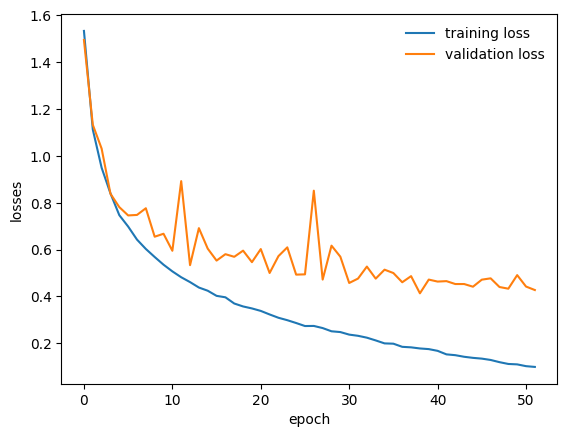

In [15]:
plt.plot(x_axis,train_losses,label="training loss")
plt.plot(x_axis,dev_losses,label="validation loss")
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.show()

In [16]:
# model=model.to("cpu")
# torch.save(model.state_dict(),model_file)